In [1]:
# =========================
# 1) IMPORTS & GLOBALS
# =========================
import os
# Avoid loading platform-specific pluggable devices (e.g., Metal on macOS) with the CPU build
os.environ["TF_USE_PLUGGABLE_DEVICE"] = "0"

import math, pathlib, datetime, json, random
import numpy as np
import tensorflow as tf

# Prefer tf.keras; fall back to tf_keras if needed
try:
    from tensorflow import keras
except Exception:
    import tf_keras as keras

from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)
from collections import Counter

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
print("TensorFlow:", tf.__version__, "| using keras module:", keras.__name__)


TensorFlow: 2.20.0 | using keras module: keras._tf_keras.keras


In [2]:
# =========================
# 2) PATHS & HYPERPARAMS
# =========================
# Data layout:
# Data/
#   train/ COVID19 NORMAL PNEUMONIA
#   test/  COVID19 NORMAL PNEUMONIA
DATA_ROOT = pathlib.Path("Data")
TRAIN_DIR = DATA_ROOT / "train"
TEST_DIR  = DATA_ROOT / "test"
assert TRAIN_DIR.exists() and TEST_DIR.exists(), "Check Data/train and Data/test paths."

IMG_SIZE  = (180, 180)
BATCH     = 32
VAL_SPLIT = 0.20
EPOCHS    = 50
LR        = 1e-3            # same LR for both models
AUTOTUNE  = tf.data.AUTOTUNE


In [3]:
# =========================
# 3) DATASETS
# =========================
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, validation_split=VAL_SPLIT, subset="training",
    seed=SEED, image_size=IMG_SIZE, batch_size=BATCH)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, validation_split=VAL_SPLIT, subset="validation",
    seed=SEED, image_size=IMG_SIZE, batch_size=BATCH)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR, shuffle=False, image_size=IMG_SIZE, batch_size=BATCH)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)


Found 5144 files belonging to 3 classes.
Using 4116 files for training.
Found 5144 files belonging to 3 classes.
Using 1028 files for validation.
Found 1288 files belonging to 3 classes.
Classes: ['COVID19', 'NORMAL', 'PNEUMONIA']


In [4]:
# =========================
# 4) PIPELINE & AUGMENTATION
# =========================
def prep(ds, training=False):
    if training:
        ds = ds.shuffle(1000, seed=SEED)
    return ds.cache().prefetch(AUTOTUNE)

train_ds_p = prep(train_ds, training=True)
val_ds_p   = prep(val_ds)
test_ds_p  = prep(test_ds)

normalizer = layers.Rescaling(1./255)
augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.10),
], name="augment")


In [5]:
# ===================================
# 5) CLASS DISTRIBUTION & WEIGHTING
# ===================================
def count_labels(ds):
    c = Counter()
    for _, y in ds:
        for k, v in Counter(y.numpy().tolist()).items():
            c[k] += v
    return c

train_counts = count_labels(train_ds)
val_counts   = count_labels(val_ds)
test_counts  = count_labels(test_ds)

def pretty(counts):
    tot = sum(counts.values())
    return {class_names[k]: (v, round(v/tot,3)) for k,v in sorted(counts.items())}

print("Train:", pretty(train_counts))
print("Val  :", pretty(val_counts))
print("Test :", pretty(test_counts))

def make_class_weights(counts):
    tot = sum(counts.values())
    return {k: tot / (len(counts)*v) for k, v in counts.items()}

class_weight = make_class_weights(train_counts)
print("Class weights:", {class_names[i]: round(w,3) for i,w in class_weight.items()})


2025-11-08 15:41:14.768235: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-08 15:41:15.704917: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train: {'COVID19': (387, 0.094), 'NORMAL': (1022, 0.248), 'PNEUMONIA': (2707, 0.658)}
Val  : {'COVID19': (73, 0.071), 'NORMAL': (244, 0.237), 'PNEUMONIA': (711, 0.692)}
Test : {'COVID19': (116, 0.09), 'NORMAL': (317, 0.246), 'PNEUMONIA': (855, 0.664)}
Class weights: {'COVID19': 3.545, 'NORMAL': 1.342, 'PNEUMONIA': 0.507}


In [6]:
# =========================
# 6) CALLBACKS
# =========================
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=7, mode="min", restore_best_weights=True)

def lr_schedule(epoch, lr):
    if epoch > 30: return lr * 0.25
    if epoch > 15: return lr * 0.50
    return lr

lr_sched = keras.callbacks.LearningRateScheduler(lr_schedule)


In [7]:
# =========================
# 7) CNN_BUILDER (shared body)
# =========================
def cnn_body(inputs):
    x = augment(inputs)
    x = normalizer(x)
    for f in (32, 64, 128):
        x = layers.Conv2D(f, 3, padding="same", activation="relu")(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Dropout(0.25)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.50)(x)
    return x


In [8]:
# =========================
# 8) MODEL A: CNN_Logits
#    - Last Dense has NO activation (raw logits)
#    - Loss uses from_logits=True
# =========================
def build_cnn_logits(input_shape=IMG_SIZE+(3,), num_classes=num_classes):
    inputs = keras.Input(shape=input_shape)
    x = cnn_body(inputs)
    logits = layers.Dense(num_classes, activation=None, name="logits")(x)
    model = keras.Model(inputs, logits, name="cnn_logits")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LR),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )
    return model

cnn_logits = build_cnn_logits()
cnn_logits.summary()


Model: "cnn_logits"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    15,859,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ logits (Dense)                  │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,953,987 (60.86 MB)

 Trainable params: 15,953,987 (60.86 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# =========================
# 9) MODEL B: CNN_Softmax
#    - Last Dense has Softmax
#    - Standard loss (from_logits=False)
# =========================
def build_cnn_softmax(input_shape=IMG_SIZE+(3,), num_classes=num_classes):
    inputs = keras.Input(shape=input_shape)
    x = cnn_body(inputs)
    probs = layers.Dense(num_classes, activation="softmax", name="softmax")(x)
    model = keras.Model(inputs, probs, name="cnn_softmax")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LR),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=["accuracy"]
    )
    return model

cnn_softmax = build_cnn_softmax()
cnn_softmax.summary()


Model: "cnn_softmax"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │    15,859,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,953,987 (60.86 MB)

 Trainable params: 15,953,987 (60.86 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# =========================
# 10) TRAIN BOTH MODELS
# =========================
history_logits = cnn_logits.fit(
    train_ds_p,
    validation_data=val_ds_p,
    epochs=EPOCHS,
    callbacks=[early_stop, lr_sched],
    class_weight=class_weight  # combats imbalance
)

history_softmax = cnn_softmax.fit(
    train_ds_p,
    validation_data=val_ds_p,
    epochs=EPOCHS,
    callbacks=[early_stop, lr_sched],
    class_weight=class_weight
)


Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 37s 249ms/step - accuracy: 0.6025 - loss: 0.9167 - val_accuracy: 0.7189 - val_loss: 0.6156 - learning_rate: 0.0010
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 31s 240ms/step - accuracy: 0.7624 - loss: 0.4881 - val_accuracy: 0.8589 - val_loss: 0.3694 - learning_rate: 0.0010
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 31s 240ms/step - accuracy: 0.8141 - loss: 0.3995 - val_accuracy: 0.8716 - val_loss: 0.3754 - learning_rate: 0.0010
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 31s 241ms/step - accuracy: 0.8290 - loss: 0.3622 - val_accuracy: 0.9144 - val_loss: 0.2409 - learning_rate: 0.0010
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 31s 239ms/step - accuracy: 0.8581 - loss: 0.3245 - val_accuracy: 0.9154 - val_loss: 0.2634 - learning_rate: 0.0010
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 31s 240ms/step - accuracy: 0.8669 - loss: 0.3077 - val_accuracy: 0.9173 - val_loss: 0.2520 - learning_rate: 0.0010
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 31s 241ms/step - accuracy: 0.8

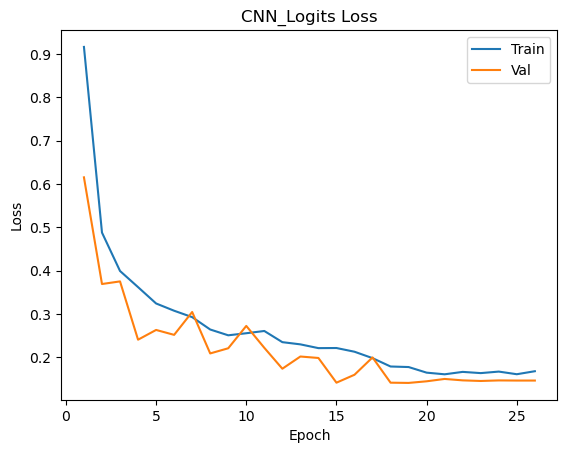

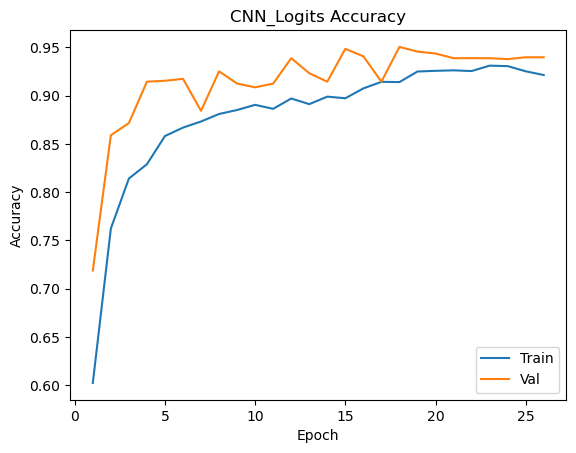

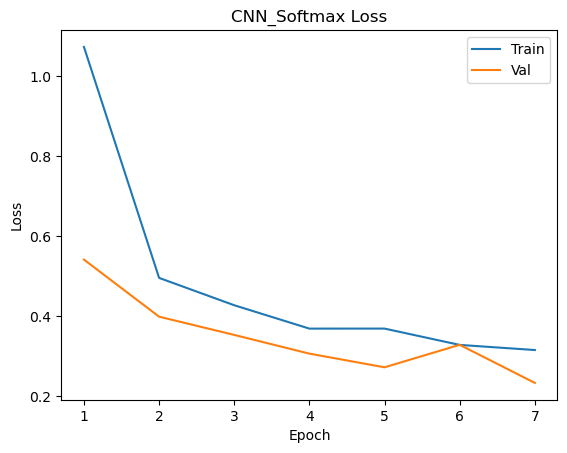

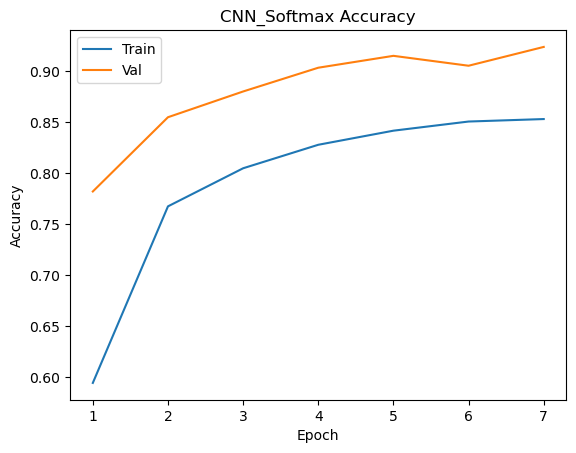

In [11]:
# =========================
# 11) PLOT TRAINING CURVES
# =========================
def plot_history(h, title=""):
    acc, val_acc = h.history["accuracy"], h.history["val_accuracy"]
    loss, val_loss = h.history["loss"], h.history["val_loss"]
    xs = range(1, len(acc)+1)

    plt.figure()
    plt.plot(xs, loss, label="Train")
    plt.plot(xs, val_loss, label="Val")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"{title} Loss"); plt.legend(); plt.show()

    plt.figure()
    plt.plot(xs, acc, label="Train")
    plt.plot(xs, val_acc, label="Val")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title(f"{title} Accuracy"); plt.legend(); plt.show()

plot_history(history_logits,  "CNN_Logits")
plot_history(history_softmax, "CNN_Softmax")


In [12]:
# =========================
# 12) EVALUATION HELPERS
# =========================
def predict_labels(model, ds, from_logits: bool):
    y_true = np.concatenate([y.numpy() for _, y in ds], axis=0)
    y_raw  = model.predict(ds, verbose=0)
    if from_logits:
        y_prob = tf.nn.softmax(y_raw, axis=1).numpy()
    else:
        y_prob = y_raw
    y_pred = np.argmax(y_prob, axis=1)
    return y_true, y_pred, y_prob

def metrics_and_report(y_true, y_pred, title):
    print(f"\n{title} – Macro P/R/F1:",
          precision_score(y_true, y_pred, average="macro"),
          recall_score(y_true, y_pred, average="macro"),
          f1_score(y_true, y_pred, average="macro"))
    print(f"{title} – Weighted P/R/F1:",
          precision_score(y_true, y_pred, average="weighted"),
          recall_score(y_true, y_pred, average="weighted"),
          f1_score(y_true, y_pred, average="weighted"))
    print(f"\n{title} – Classification report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

def plot_cm(cm, labels, title):
    plt.figure()
    plt.imshow(cm, cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.xticks(range(len(labels)), labels, rotation=45)
    plt.yticks(range(len(labels)), labels)
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.colorbar(); plt.tight_layout(); plt.show()


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.9224 - loss: 0.1835
CNN_Logits – Test: {'accuracy': 0.9223602414131165, 'loss': 0.1834571659564972}
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8020 - loss: 0.5298
CNN_Softmax – Test: {'accuracy': 0.8020186424255371, 'loss': 0.5298091173171997}


2025-11-08 15:58:45.910987: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



CNN_Logits – Macro P/R/F1: 0.9112243533907182 0.939331890587995 0.9219372054169157
CNN_Logits – Weighted P/R/F1: 0.9329803975909263 0.922360248447205 0.9245298335435503

CNN_Logits – Classification report:
              precision    recall  f1-score   support

     COVID19     0.9652    0.9569    0.9610       116
      NORMAL     0.7850    0.9558    0.8620       317
   PNEUMONIA     0.9835    0.9053    0.9428       855

    accuracy                         0.9224      1288
   macro avg     0.9112    0.9393    0.9219      1288
weighted avg     0.9330    0.9224    0.9245      1288


CNN_Softmax – Macro P/R/F1: 0.7514655836646167 0.853587090270608 0.7849325712339411
CNN_Softmax – Weighted P/R/F1: 0.8473326511890171 0.8020186335403726 0.8097559251775196

CNN_Softmax – Classification report:
              precision    recall  f1-score   support

     COVID19     0.6879    0.9310    0.7912       116
      NORMAL     0.6093    0.8707    0.7169       317
   PNEUMONIA     0.9572    0.7591    0

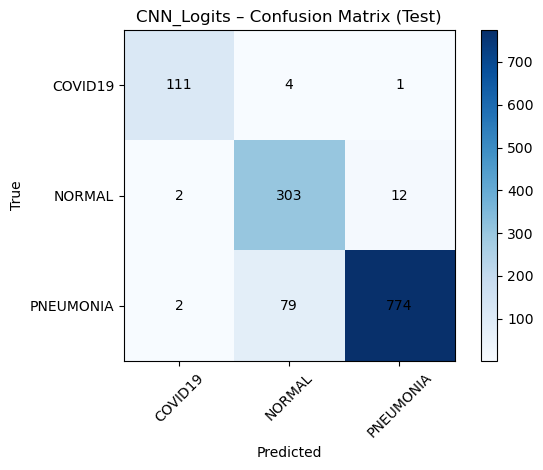

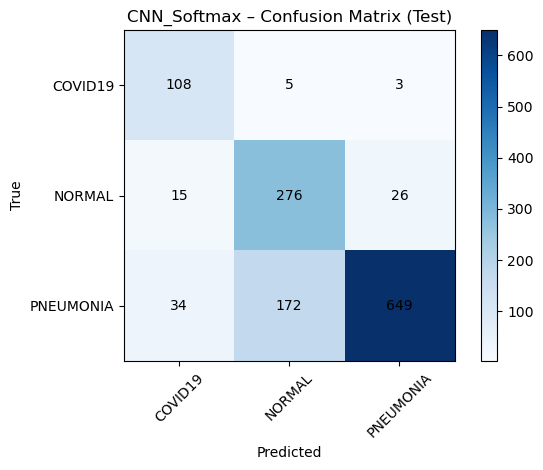

In [13]:
# =========================
# 13) TEST ACCURACY + FULL METRICS
# =========================
print("CNN_Logits – Test:",  cnn_logits.evaluate(test_ds_p, return_dict=True))
print("CNN_Softmax – Test:", cnn_softmax.evaluate(test_ds_p, return_dict=True))

y_true_L, y_pred_L, _ = predict_labels(cnn_logits,  test_ds_p, from_logits=True)
y_true_S, y_pred_S, _ = predict_labels(cnn_softmax, test_ds_p, from_logits=False)

metrics_and_report(y_true_L, y_pred_L, "CNN_Logits")
metrics_and_report(y_true_S, y_pred_S, "CNN_Softmax")

cm_L = confusion_matrix(y_true_L, y_pred_L)
cm_S = confusion_matrix(y_true_S, y_pred_S)
plot_cm(cm_L, class_names, "CNN_Logits – Confusion Matrix (Test)")
plot_cm(cm_S, class_names, "CNN_Softmax – Confusion Matrix (Test)")


In [14]:
# =========================
# 14) SAVE ARTIFACTS
# =========================
OUT_DIR = pathlib.Path("runs") / datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
OUT_DIR.mkdir(parents=True, exist_ok=True)

cnn_logits.save(OUT_DIR / "cnn_logits.keras")
cnn_softmax.save(OUT_DIR / "cnn_softmax.keras")

with open(OUT_DIR / "history_cnn_logits.json", "w") as f:
    json.dump(history_logits.history, f, indent=2)
with open(OUT_DIR / "history_cnn_softmax.json", "w") as f:
    json.dump(history_softmax.history, f, indent=2)

with open(OUT_DIR / "setup.json", "w") as f:
    json.dump({
        "img_size": IMG_SIZE, "batch": BATCH, "val_split": VAL_SPLIT,
        "epochs_trained_logits": len(history_logits.history["loss"]),
        "epochs_trained_softmax": len(history_softmax.history["loss"]),
        "classes": class_names, "seed": SEED, "tf": tf.__version__
    }, f, indent=2)

print("Saved to:", OUT_DIR.resolve())


Saved to: /Users/thabochesane/Downloads/COS801/runs/20251108_155850
